In [1]:
# ruff: noqa
%reload_ext autoreload
%autoreload 2

# Standard library
import os
import json

# External libraries
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import rootutils
import hydra

# Local imports
import ml_project_2_mlp.utils as utils

/Users/jonas-mika/Library/Caches/pypoetry/virtualenvs/ml-project-2-mlp-a6NSXBdT-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Reinitialize hydra on every run
hydra.core.global_hydra.GlobalHydra.instance().clear()
h = hydra.initialize(config_path="../conf", job_name="eda", version_base=None)

# Setup root environment
root_path = rootutils.setup_root(".")
rootutils.set_root(
    path=root_path,
    project_root_env_var=True,
)

In [3]:
# Costs per token based on https://openai.com/pricing
GPT4_COST_PER_INP_TOKEN = 0.00001
GPT4_COST_PER_OUT_TOKEN = 0.00003
GPT3_5_COST_PER_INP_TOKEN = 0.000001
GPT3_5_COST_PER_OUT_TOKEN = 0.000002

In [4]:
sns.set_style("dark")
sns.set_palette("gist_stern")

## Websites

---

There are three copora of websites in this dataset:

* `original`: 770 websites from the crowdsourced dataset from the [Homepage2Vec paper](https://arxiv.org/abs/1905.09786)
* `gpt`: 250 common websites obtained by prompting GPT-4 (see [Prompts](https://chat.openai.com/share/a76c8b9b-a659-4b15-9ab0-d94af4733d58))
* `curlie`: A filtered version of the [curlie](https://curlie.org) dataset, containing ~1M websites

For each website, the repository contains a CSV file at the path `data/raw/<corpus>.csv` with the two columns - `wid` and `url`. The `wid` is a unique identifier for the website, and the `url` is the URL of the website.

In [5]:
# Initialise Config
original_cfg = hydra.compose(config_name="eda", overrides=["data=original"])
gpt_cfg = hydra.compose(config_name="eda", overrides=["data=gpt"])
curlie_cfg = hydra.compose(config_name="eda", overrides=["data=curlie"])

In [6]:
# Load categories
path = os.path.join(root_path, "data", "meta", "categories.json")
with open(path) as f:
    categories = json.load(f)

print(f"Classifying in {len(categories)} categories: {', '.join(categories)}")

Classifying in 14 categories: Arts, Business, Computers, Games, Health, Home, Kids_and_Teens, News, Recreation, Reference, Science, Shopping, Society, Sports


### Original Data

This is the data that was used to test the model in the original paper. 

In [7]:
# Raw data
original_data = hydra.utils.instantiate(original_cfg.data)

raw_data = original_data.get_raw_data()
processed_data = original_data.get_processed_data()
embedded_data = original_data.get_embeddings()

print(f"Total number of samples: {len(raw_data)}")
raw_data.head(5)

Total number of samples: 769


,wid,url
0,1161124,http://www.pointlesssites.com
1,1081241,http://www.connecticutplastics.com
2,1162420,http://99percentinvisible.org
3,1146040,http://www.medicaid.gov
4,1117243,http://www.graalonline.com


In [8]:
# Example of processed website
wid = list(processed_data.keys())[0]
data = processed_data[wid]

print(f"Collected data on {list(data.keys())}")

# Show some examples
print(f"\nTitle: {data['title']}")
print(f"Description: {data['description']}")
print(f"Keywords: {data['keywords']}")
print(f"Tags: {data['metatags']}")
print(f"Domain: {data['domain']}")
print(f"TLD: {data['tld']}")

Collected data on ['title', 'description', 'keywords', 'links', 'sentences', 'metatags', 'tld', 'domain']

Title: PointlessSites.com  Fun Things To Do When You're Bored
Description: Are you bored? Want something fun to do? Check out these funny websites, pointless facts and stupid pictures brought to you by Pointless Sites!
Keywords: ['Pointless', 'Sites', 'portal,', 'useless', 'pointlessness']
Tags: ['description', 'viewport', 'author', 'keywords', 'robots', 'copyright']
Domain: pointlesssites
TLD: com


In [9]:
def get_num_featues(feat):
    return len([w[feat] for w in processed_data.values() if w[feat] is not None and w[feat] != []])

n = len(processed_data)
n_tld = get_num_featues("tld")
n_domain = get_num_featues("domain")
n_tags = get_num_featues("metatags")
n_titles = get_num_featues("title")
n_descriptions = get_num_featues("description")
n_keywords = get_num_featues("keywords")
n_links = get_num_featues("links")

# Print results
print(f"ℹ️ Number of sites with TLD: {n_tld/n*100:.2f}%")
print(f"ℹ️ Number of sites with domain: {n_domain/n*100:.2f}%")
print(f"ℹ️ Number of sites with tags: {n_tags/n*100:.2f}%")
print(f"ℹ️ Number of sites with title: {n_titles/n*100:.2f}%")
print(f"ℹ️ Number of sites with description: {n_descriptions/n*100:.2f}%")
print(f"ℹ️ Number of sites with keywords: {n_keywords/n*100:.2f}%")
print(f"ℹ️ Number of sites with links: {n_links/n*100:.2f}%")

ℹ️ Number of sites with TLD: 100.00%
ℹ️ Number of sites with domain: 100.00%
ℹ️ Number of sites with tags: 93.69%
ℹ️ Number of sites with title: 98.42%
ℹ️ Number of sites with description: 54.93%
ℹ️ Number of sites with keywords: 19.58%
ℹ️ Number of sites with links: 89.88%


### GPT

In [10]:
# Raw data
gpt_data = hydra.utils.instantiate(gpt_cfg.data)

raw_data = gpt_data.get_raw_data()
processed_data = gpt_data.get_processed_data()
embedded_jdata = gpt_data.get_embeddings()

print(f"Total number of samples: {len(raw_data)}")
raw_data.head(5)

Total number of samples: 250


,wid,url
0,0,google.com
1,1,facebook.com
2,2,youtube.com
3,3,amazon.com
4,4,wikipedia.org


In [11]:
# Example of processed website
wid = list(processed_data.keys())[0]
data = processed_data[wid]

print(f"Collected data on {list(data.keys())}")

# Show some examples
print(f"\nTitle: {data['title']}")
print(f"Description: {data['description']}")
print(f"Keywords: {data['keywords']}")
print(f"Tags: {data['metatags']}")
print(f"Domain: {data['domain']}")
print(f"TLD: {data['tld']}")

Collected data on ['title', 'description', 'keywords', 'links', 'sentences', 'metatags', 'tld', 'domain']

Title: Google
Description: None
Keywords: []
Tags: ['referrer']
Domain: google
TLD: com


In [12]:
def get_num_featues(feat):
    return len([w[feat] for w in processed_data.values() if w[feat] is not None and w[feat] != []])

n = len(processed_data)
n_tld = get_num_featues("tld")
n_domain = get_num_featues("domain")
n_tags = get_num_featues("metatags")
n_titles = get_num_featues("title")
n_descriptions = get_num_featues("description")
n_keywords = get_num_featues("keywords")
n_links = get_num_featues("links")

# Print results
print(f"ℹ️ Number of sites with TLD: {n_tld/n*100:.2f}%")
print(f"ℹ️ Number of sites with domain: {n_domain/n*100:.2f}%")
print(f"ℹ️ Number of sites with tags: {n_tags/n*100:.2f}%")
print(f"ℹ️ Number of sites with title: {n_titles/n*100:.2f}%")
print(f"ℹ️ Number of sites with description: {n_descriptions/n*100:.2f}%")
print(f"ℹ️ Number of sites with keywords: {n_keywords/n*100:.2f}%")
print(f"ℹ️ Number of sites with links: {n_links/n*100:.2f}%")

ℹ️ Number of sites with TLD: 100.00%
ℹ️ Number of sites with domain: 100.00%
ℹ️ Number of sites with tags: 98.17%
ℹ️ Number of sites with title: 96.35%
ℹ️ Number of sites with description: 86.30%
ℹ️ Number of sites with keywords: 22.37%
ℹ️ Number of sites with links: 85.84%


### Curlie

In [13]:
# Raw data
curlie_data = hydra.utils.instantiate(curlie_cfg.data)

raw_data = curlie_data.get_raw_data()
processed_data = curlie_data.get_processed_data()
embedded_jdata = curlie_data.get_embeddings()

print(f"Total number of samples: {len(raw_data)}")
raw_data.head(5)

Total number of samples: 10000


,wid,url
0,917678,www.winandsoft.fr
1,443072,gaude-ag.de
2,728091,www.housing.ucsb.edu
3,132596,www.daccad.nl
4,464355,www.rockhall.com


In [14]:
# Example of processed website
wid = list(processed_data.keys())[0]
data = processed_data[wid]

print(f"Collected data on {list(data.keys())}")

# Show some examples
print(f"\nTitle: {data['title']}")
print(f"Description: {data['description']}")
print(f"Keywords: {data['keywords']}")
print(f"Tags: {data['metatags']}")
print(f"Domain: {data['domain']}")
print(f"TLD: {data['tld']}")

Collected data on ['title', 'description', 'keywords', 'links', 'sentences', 'metatags', 'tld', 'domain']

Title: Logiciel bibliothèque, médiathèque, vidéothèque.
Description: Logiciel bibliothèque  logiciel permettant le catalogage de tous types de documents ou supports pour les besoins d'une bibliothèque. Le logiciel bibliothèque vous garantit la gestion documentaire la plus efficace (livres, cartes, manuscrits, incunables, etc.).
Keywords: ['logiciel', 'bibliotheque,logiciel', 'mediatheque,logiciel', 'gestion', 'bibliotheque,logiciel', 'gestion', 'mediatheque,logiciel,bibliotheque,mediatheque']
Tags: ['description', 'copyright', 'robots', 'keywords', 'author']
Domain: winandsoft
TLD: fr


In [15]:
def get_num_featues(feat):
    return len([w[feat] for w in processed_data.values() if w[feat] is not None and w[feat] != []])

n = len(processed_data)
n_tld = get_num_featues("tld")
n_domain = get_num_featues("domain")
n_tags = get_num_featues("metatags")
n_titles = get_num_featues("title")
n_descriptions = get_num_featues("description")
n_keywords = get_num_featues("keywords")
n_links = get_num_featues("links")

# Print results
print(f"ℹ️ Number of sites with TLD: {n_tld/n*100:.2f}%")
print(f"ℹ️ Number of sites with domain: {n_domain/n*100:.2f}%")
print(f"ℹ️ Number of sites with tags: {n_tags/n*100:.2f}%")
print(f"ℹ️ Number of sites with title: {n_titles/n*100:.2f}%")
print(f"ℹ️ Number of sites with description: {n_descriptions/n*100:.2f}%")
print(f"ℹ️ Number of sites with keywords: {n_keywords/n*100:.2f}%")
print(f"ℹ️ Number of sites with links: {n_links/n*100:.2f}%")

ℹ️ Number of sites with TLD: 100.00%
ℹ️ Number of sites with domain: 100.00%
ℹ️ Number of sites with tags: 95.47%
ℹ️ Number of sites with title: 98.28%
ℹ️ Number of sites with description: 62.95%
ℹ️ Number of sites with keywords: 27.29%
ℹ️ Number of sites with links: 91.62%


## Labelers

---

There are multiple GPT labeler instances that can be used to label the data. The labelers are defined in the labelers module and are identified by a `context`, `model` and `fewshow` parameter. The `context` parameter defines the context that is used to prompt the model. The `model` parameter defines the model that is used to generate the labels. The `fewshot` parameter defines whether the model is trained in a few-shot manner or not.

| Parameter | Variants | Description |
| --- | --- | ---  |
| `context` | `context1` | Uses the `tld`, `domain` and `metatags` as context |
| | `context2` | Uses the `tld`, `domain`, `metatags`, `links` and `text` as context |
| | `context3` | Uses the `tld`, `domain`, `metatags`, `links`, `text` and `images` as context |
| `model` | `gpt3.5` | Uses GPT-3.5 (`gpt-3.5-turbo-1106`) |
| | `gpt4` | Uses GPT-4 (`gpt-4-1106-preview`) |
| `fewshot` | `fewshot` | Injects an example website and label into the system prompt |
| | `zeroshot` | Does not inject any example website or label into the system prompt |

We are considering all contexts and few-shot settings for the GPT-3.5 model, but only the `context2` for the GPT-4 model. Additionally, we have the `human` labeler which simply loads the annotatations for the `original` dataset from the [Homepage2Vec paper](https://arxiv.org/abs/1905.09786).

In [16]:
# Initialise configuration for all labelers
gpt_labeler_names = ["gpt3.5-zeroshot-context1", "gpt3.5-oneshot-context1", "gpt3.5-zeroshot-context2", "gpt3.5-oneshot-context2", "gpt3.5-zeroshot-context3", "gpt3.5-oneshot-context3", "gpt4-zeroshot-context2", "gpt4-oneshot-context2"] 

gpt_labelers_cfg = {labeler: hydra.compose(config_name="eda", overrides=[f"labeler={labeler}"]) for labeler in gpt_labeler_names}

In [17]:
# Instantiate data
original_data_cfg = hydra.compose(config_name="eda", overrides=["data=original", "data.num_samples=100"])
original_data = hydra.utils.instantiate(original_data_cfg.data)

In [18]:
# Instantiate labelers
gpt_labelers = {labeler: hydra.utils.instantiate(cfg.labeler, data=original_data) for labeler, cfg in gpt_labelers_cfg.items()}

In [19]:
# Instatntiate labelers dataframe
def get_info(labeler):
    return {
        "model": labeler.model,
        "context": labeler.name.split("-")[-1],
        "shot": labeler.fewshot,
    }

labeler_info = pd.DataFrame([get_info(labeler) for labeler in gpt_labelers.values()], index=gpt_labelers.keys())
labeler_info

,model,context,shot
gpt3.5-zeroshot-context1,gpt-3.5-turbo-1106,context1,False
gpt3.5-oneshot-context1,gpt-3.5-turbo-1106,context1,True
gpt3.5-zeroshot-context2,gpt-3.5-turbo-1106,context2,False
gpt3.5-oneshot-context2,gpt-3.5-turbo-1106,context2,True
gpt3.5-zeroshot-context3,gpt-3.5-turbo-1106,context3,False
gpt3.5-oneshot-context3,gpt-3.5-turbo-1106,context3,True
gpt4-zeroshot-context2,gpt-4-1106-preview,context2,False
gpt4-oneshot-context2,gpt-4-1106-preview,context2,True


Let's verify that the labelers are working as expected by checking the number of labeled webpages.

In [20]:
num_processed_websites = len(original_data.get_processed_data())

print(f"ℹ️ Number of processed websites: {num_processed_websites}")
for name, labeler in gpt_labelers.items():
    num_labels = len(labeler.get_labels())
    print(f"ℹ️ Number of {name} labels: {num_labels}")

ℹ️ Number of processed websites: 99
ℹ️ Number of gpt3.5-zeroshot-context1 labels: 99
ℹ️ Number of gpt3.5-oneshot-context1 labels: 99
ℹ️ Number of gpt3.5-zeroshot-context2 labels: 99
ℹ️ Number of gpt3.5-oneshot-context2 labels: 99
ℹ️ Number of gpt3.5-zeroshot-context3 labels: 99
ℹ️ Number of gpt3.5-oneshot-context3 labels: 99
ℹ️ Number of gpt4-zeroshot-context2 labels: 99
ℹ️ Number of gpt4-oneshot-context2 labels: 99


### Labeling statistics

Let's investigate some statistics about the labelers. We will compute:

* The average number of labels per website
* The number of valid labels
* The number of invalid labels
* The average time taken to label a website
* The average number of prompt and completion tokens used to label a website
* The estimated cost of labeling the entire dataset

In [21]:
def get_statistics(labeler):
    statistics = {"valid": 0, "invalid": 0, "lpp": [], "durations": [], "prompt_tokens": [], "completion_tokens": []}
    for website in labeler.get_labels().values():
        if not website["is_valid"]:
            statistics["invalid"] += 1
            continue

        statistics["valid"] += 1
        statistics["lpp"].append(sum(website["labels"]))
        statistics["durations"].append(website["duration"])
        statistics["prompt_tokens"].append(website["prompt_tokens"])
        statistics["completion_tokens"].append(website["completion_tokens"])

    lpps = np.array(statistics["lpp"])
    durations = np.array(statistics["durations"])
    prompt_tokens = np.array(statistics["prompt_tokens"])
    completion_tokens = np.array(statistics["completion_tokens"])

    statistics["lpp"] = f"{lpps.mean():.2f} ± {lpps.std():.2f}"
    statistics["durations"] = f"{durations.mean():.2f} ± {durations.std():.2f}"
    statistics["prompt_tokens"] = f"{prompt_tokens.mean():.2f} ± {prompt_tokens.std():.2f}"
    statistics["completion_tokens"] = f"{completion_tokens.mean():.2f} ± {completion_tokens.std():.2f}"
    
    # Compute estimated cost
    model = labeler.model
    COST_PER_INP_TOKEN = GPT4_COST_PER_INP_TOKEN if "gpt4" in model else GPT3_5_COST_PER_INP_TOKEN
    COST_PER_OUT_TOKEN = GPT4_COST_PER_OUT_TOKEN if "gpt4" in model else GPT3_5_COST_PER_OUT_TOKEN

    statistics["estimated_cost"] = f"{(prompt_tokens.sum() * COST_PER_INP_TOKEN + completion_tokens.sum() * COST_PER_OUT_TOKEN):.2f}"

    return statistics

In [22]:
labeler_statistics = pd.DataFrame([get_statistics(labeler) for labeler in gpt_labelers.values()], index=gpt_labelers.keys())
labeler_statistics

,valid,invalid,lpp,durations,prompt_tokens,completion_tokens,estimated_cost
gpt3.5-zeroshot-context1,99,0,0.46 ± 0.57,3.47 ± 0.43,151.32 ± 13.93,107.52 ± 2.74,0.04
gpt3.5-oneshot-context1,99,0,1.02 ± 0.95,2.98 ± 0.33,295.32 ± 13.93,92.00 ± 0.00,0.05
gpt3.5-zeroshot-context2,99,0,1.41 ± 0.94,3.48 ± 0.50,182.63 ± 55.50,107.35 ± 3.15,0.04
gpt3.5-oneshot-context2,99,0,1.93 ± 1.11,3.18 ± 1.29,401.63 ± 55.50,92.32 ± 2.25,0.06
gpt3.5-zeroshot-context3,99,0,1.66 ± 1.05,3.48 ± 0.52,324.40 ± 81.49,108.00 ± 0.00,0.05
gpt3.5-oneshot-context3,99,0,2.32 ± 1.25,3.12 ± 0.45,566.40 ± 81.49,93.45 ± 4.60,0.07
gpt4-zeroshot-context2,99,0,2.20 ± 1.14,6.30 ± 1.81,182.63 ± 55.50,106.00 ± 7.17,0.04
gpt4-oneshot-context2,99,0,2.75 ± 1.37,5.72 ± 1.80,401.63 ± 55.50,92.91 ± 4.62,0.06


### Class Distribution

In [23]:
def get_dist(labeler):
    labels = np.array([website["labels"] for website in labeler.get_labels().values()])
    return {category: count for category, count in zip(categories, labels.sum(0))}

dists = {name: get_dist(labeler) for name, labeler in gpt_labelers.items()}

✅ Plotted labelled category distribution


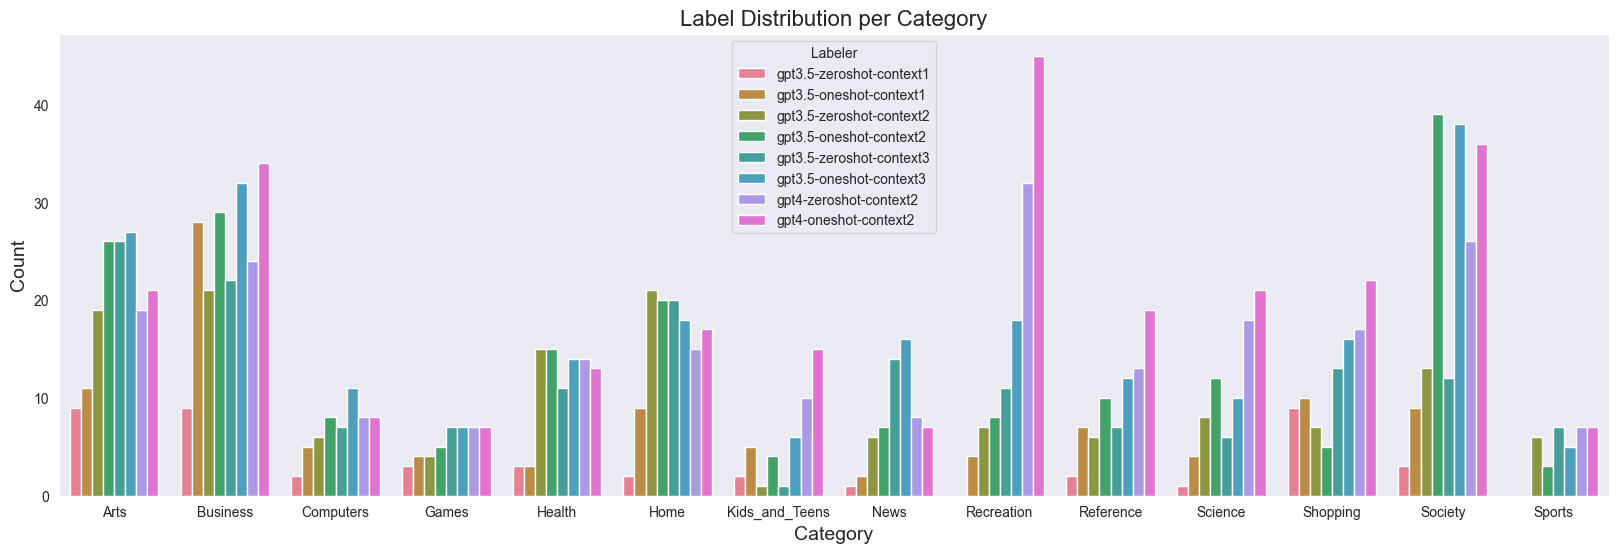

In [24]:
rows = []
for labeler, class_dist in dists.items():
    for category, count in class_dist.items():
        rows.append({"labeler": labeler, "category": category, "count": count})

labeling_dists = pd.DataFrame(rows)

fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(
    labeling_dists,
    x="category",
    y="count",
    hue="labeler",
    ax=ax
)
ax.get_legend().set_title("Labeler")
ax.set_xlabel("Category", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.set_title("Label Distribution per Category", fontsize=16)

print(f"✅ Plotted labelled category distribution")

### Labeling Quality

The goal of all GPT labelers is to replicate the ground truth labels provide by the human annotators as closely as possible. As we only have human annotations for the original dataset, we can only evaluate the labelers on this dataset.

In [25]:
# Instatiate human labeler
original_cfg = hydra.compose(config_name="eda", overrides=["data=original"])
human_labeler_cfg = hydra.compose(config_name="eda", overrides=["labeler=human", "data=original"])
original_data = hydra.utils.instantiate(original_cfg.data)
human_labeler = hydra.utils.instantiate(human_labeler_cfg.labeler, data=original_data)

In [26]:
def match_labels(labeler1, labeler2, subset = None):
    labels1 = labeler1.get_labels()
    labels2 = labeler2.get_labels()
    wid1 = set(labels1.keys())
    wid2 = set(labels2.keys())
    matched_wid = wid1 & wid2
    if subset:
        matched_wid = matched_wid & subset

    labels1 = np.array([labels1[wid]["labels"] for wid in matched_wid])
    labels2 = np.array([labels2[wid]["labels"] for wid in matched_wid])

    return labels1, labels2

In [27]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

labeler_perf = []
for name, labeler in gpt_labelers.items():
    labels1, labels2 = match_labels(human_labeler, labeler)

    acc = accuracy_score(labels1.flatten(), labels2.flatten())
    subset_acc = accuracy_score(labels1, labels2)
    macro_f1 = f1_score(labels1, labels2, average="macro")
    micro_f1 = f1_score(labels1, labels2, average="micro")
    weighted_f1 = f1_score(labels1, labels2, average="weighted")
    macro_precision = precision_score(labels1, labels2, average="macro", zero_division=0)
    micro_precision = precision_score(labels1, labels2, average="micro", zero_division=0)
    macro_recall = recall_score(labels1, labels2, average="macro", zero_division=0)
    micro_recall = recall_score(labels1, labels2, average="micro", zero_division=0)

    labeler_perf.append({
        "acc": acc,
        "subset_acc": subset_acc,
        "macro_f1": macro_f1,
        "micro_f1": micro_f1,
        "weighted_f1": weighted_f1,
        "macro_precision": macro_precision,
        "micro_precision": micro_precision,
        "macro_recall": macro_recall,
        "micro_recall": micro_recall,
    })

labeler_perf = pd.DataFrame(labeler_perf, index=gpt_labelers.keys())
labeler_perf

,acc,subset_acc,macro_f1,micro_f1,weighted_f1,macro_precision,micro_precision,macro_recall,micro_recall
gpt3.5-zeroshot-context1,0.864358,0.101010,0.230493,0.241935,0.221214,0.523810,0.652174,0.169755,0.148515
gpt3.5-oneshot-context1,0.854978,0.101010,0.289465,0.336634,0.330627,0.454133,0.504950,0.235223,0.252475
gpt3.5-zeroshot-context2,0.873016,0.212121,0.476277,0.485380,0.496569,0.626982,0.592857,0.445804,0.410891
gpt3.5-oneshot-context2,0.863636,0.161616,0.464424,0.519084,0.527164,0.509048,0.534031,0.474404,0.504950
gpt3.5-zeroshot-context3,0.858586,0.151515,0.441378,0.464481,0.482152,0.557755,0.518293,0.461365,0.420792
gpt3.5-oneshot-context3,0.839827,0.111111,0.416422,0.486111,0.507938,0.399970,0.456522,0.489728,0.519802
gpt4-zeroshot-context2,0.867244,0.212121,0.522528,0.561905,0.579866,0.500409,0.541284,0.615227,0.584158
gpt4-oneshot-context2,0.857143,0.101010,0.533626,0.582278,0.622341,0.490611,0.507353,0.668551,0.683168


### Analysis

In [28]:
# Join with labeling statistics
labelers_df = pd.concat([labeler_info, labeler_statistics, labeler_perf], axis=1)

In [29]:
# Top-k performing labeler
top_k = 5
labelers_df.sort_values("macro_f1", ascending=False).head(top_k)

,model,context,shot,valid,invalid,lpp,durations,prompt_tokens,completion_tokens,estimated_cost,acc,subset_acc,macro_f1,micro_f1,weighted_f1,macro_precision,micro_precision,macro_recall,micro_recall
gpt4-oneshot-context2,gpt-4-1106-preview,context2,True,99,0,2.75 ± 1.37,5.72 ± 1.80,401.63 ± 55.50,92.91 ± 4.62,0.06,0.857143,0.101010,0.533626,0.582278,0.622341,0.490611,0.507353,0.668551,0.683168
gpt4-zeroshot-context2,gpt-4-1106-preview,context2,False,99,0,2.20 ± 1.14,6.30 ± 1.81,182.63 ± 55.50,106.00 ± 7.17,0.04,0.867244,0.212121,0.522528,0.561905,0.579866,0.500409,0.541284,0.615227,0.584158
gpt3.5-zeroshot-context2,gpt-3.5-turbo-1106,context2,False,99,0,1.41 ± 0.94,3.48 ± 0.50,182.63 ± 55.50,107.35 ± 3.15,0.04,0.873016,0.212121,0.476277,0.485380,0.496569,0.626982,0.592857,0.445804,0.410891
gpt3.5-oneshot-context2,gpt-3.5-turbo-1106,context2,True,99,0,1.93 ± 1.11,3.18 ± 1.29,401.63 ± 55.50,92.32 ± 2.25,0.06,0.863636,0.161616,0.464424,0.519084,0.527164,0.509048,0.534031,0.474404,0.504950
gpt3.5-zeroshot-context3,gpt-3.5-turbo-1106,context3,False,99,0,1.66 ± 1.05,3.48 ± 0.52,324.40 ± 81.49,108.00 ± 0.00,0.05,0.858586,0.151515,0.441378,0.464481,0.482152,0.557755,0.518293,0.461365,0.420792


✅ Plotted labeler as function of model, context and shot


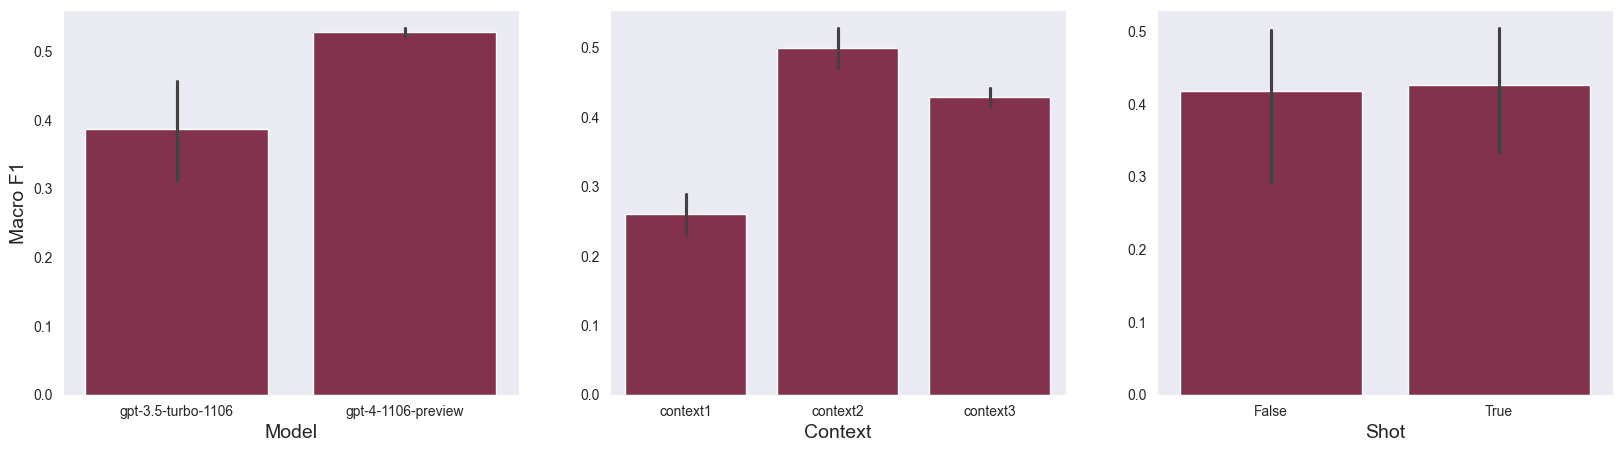

In [30]:
# Univariate performance
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
xs = ["model", "context", "shot"]

for ax, x in zip(axs, xs):
    sns.barplot(
        data=labelers_df,
        x=x,
        y="macro_f1",
        ax=ax
    )
    ax.set_xlabel(x.capitalize(), fontsize=14)
    ax.set_ylabel("")

axs[0].set_ylabel("Macro F1", fontsize=14)

print(f"✅ Plotted labeler as function of model, context and shot")

✅ Plotted figure.


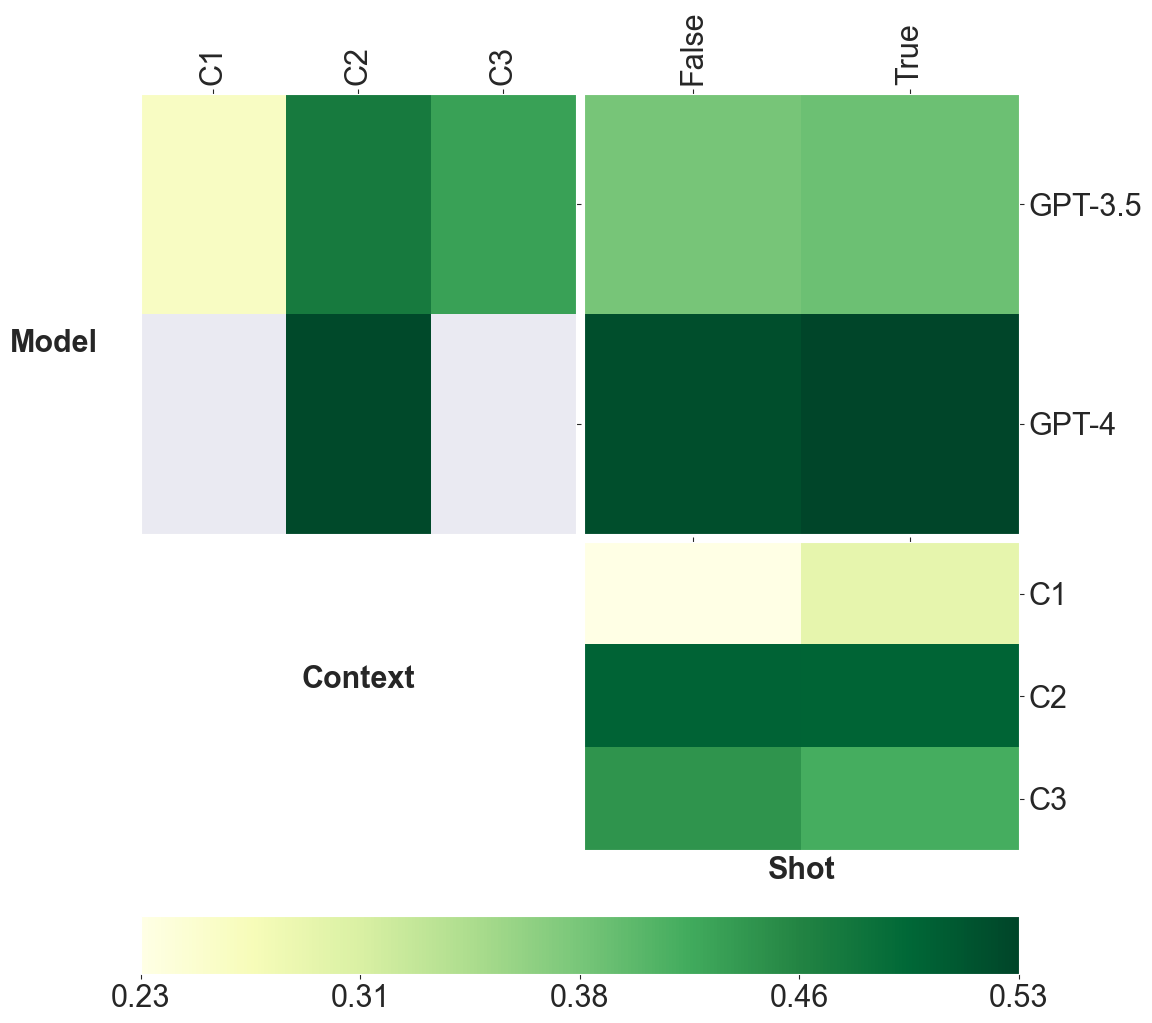

In [31]:
# Labeler parameters
params = ["model", "context", "shot"]

rename_dict = {
    "gpt-3.5-turbo-1106": "GPT-3.5",
    "gpt-4-1106-preview": "GPT-4",
    "context1": "C1",
    "context2": "C2",
    "context3": "C3",
    "shot": "Shot",
    "model": "Model",
    "context": "Context",
}

fig = utils.grid(labelers_df, params, metric="mean", cmap="YlGn", figsize=(10, 10), rename_dict=rename_dict) 
print(f"✅ Plotted figure.")